# Sensitivity shift fit model : SI

Sensitivity of choices on shift fit model for reanalysis

Compare:
- baseline model: shift fit with only loc as linear function of GMST (1950-2019 data)
- same model, 1901-2019 data
- shift fit with loc and sigma as linear function of GMST (1950-2019 data)

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, statsmodels

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from scipy.stats import norm

# import my variables settings functions from other scripts
from settings import *
from functions import *
from utils import *
from plotscript import *

sys.path.append('../dist_cov/dist_cov/')
import distributions as distributions


In [2]:
start_message()

flags: {'models': 'ISIMIP3a', 'experiment': 'obsclim', 'metric': 'WBGT', 'method': 'shift_fit', 'time_method': None, 'shift_sigma': True, 'shift_period': (1901, 2019), 'shift_loglike': None, 'chunk_version': 0, 'var': 'wbgt'}
var: wbgt
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 'EC-Earth3', 'UKESM1-0-LL', 'MPI-ESM1-2-HR', 'CNRM-ESM2-1']
datasets: ['GSWP3-W5E5', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_

In [3]:
from dask.distributed import Client 
client = Client()
client

/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41495 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41495/status,
Dashboard: http://127.0.0.1:41495/status,Workers: 2
Total threads: 2,Total memory: 40.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41947,Workers: 2
Dashboard: http://127.0.0.1:41495/status,Total threads: 2
Started: Just now,Total memory: 40.00 GiB
Comm: tcp://127.0.0.1:35339,Total threads: 1
Dashboard: http://127.0.0.1:41617/status,Memory: 20.00 GiB
Nanny: tcp://127.0.0.1:38127,


In [4]:
figdir = os.path.join(figdirs, 'fig_feb25')

dir_shift_fit = 'forster2024-hitol-nan'


# Functions

In [5]:
def calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2022,GWI=1.3):

    gmst_pres = float(gmst_smo.loc[year_pres].iloc[0]) # take smoothed or not smoothed covariate ?? 
    gmst_pi = float(gmst_pres - GWI)

    b0 = da_params.sel(params='b0')
    b1 = da_params.sel(params='b1')


    if len(da_params.params) >3:
        sigma_b0 = da_params.sel(params='sigma_b0')
        sigma_b1 = da_params.sel(params='sigma_b1')
        norm_pi, norm_pres = norm(loc=b0+b1*gmst_pi, scale=sigma_b0+sigma_b1*gmst_pi), norm(loc=b0+b1*gmst_pres, scale=sigma_b0+sigma_b1*gmst_pres)
    elif len(da_params.params) ==3:
        sigma_b0 = da_params.sel(params='sigma')
        norm_pi, norm_pres = norm(loc=b0+b1*gmst_pi, scale=sigma_b0), norm(loc=b0+b1*gmst_pres, scale=sigma_b0)

    data = norm_pres.sf(threshold)
    da_p1 = xr.DataArray(
        data=data,
        dims=["dataset", "month", "lat", "lon", ],
        coords=dict(
            lon=(["lon"], da_params.lon.data),
            lat=(["lat"], da_params.lat.data),
            month=da_params.month.data,
            dataset=da_params.dataset.data) )
    
    data = norm_pi.sf(threshold)
    da_p0 = xr.DataArray(
        data=data,
        dims=[ "dataset", "month", "lat", "lon"],
        coords=dict(
            lon=(["lon"], da_params.lon.data),
            lat=(["lat"], da_params.lat.data),
            month=da_params.month.data,
            dataset=da_params.dataset.data) )

    days_in_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) # ignoring leap years

    # add dimension for correct multiplication
    days_in_month_da = xr.DataArray(days_in_month, dims=['month'], coords={'month': da_p1['month']})

    # calc nAHD per month and per year
    da_nAHD_mo = (da_p1 - da_p0) * days_in_month_da
    
    da_nAHD = da_nAHD_mo.sum(dim='month')


    return da_nAHD, da_nAHD_mo, da_p0, da_p1

In [6]:
def get_smoothed_gmst(ntime=4):
    df_gmst = pd.read_csv(os.path.join(datadirs,'gmst/gmst-obs/forster2024/annual_averages.csv')).rename(
    columns={'timebound_lower':'year'}).set_index('year')[['gmst']]
    gmst_smo = pd.DataFrame(apply_lowess(df_gmst, df_gmst.index, ntime=ntime))

    return gmst_smo

# Compare different models : 

## Prep data

In [41]:
flags['models']='ISIMIP3a'
dirname = 'output_shift-fit' 
dir_shift_fit = 'forster2024-hitol-nan' # to include the sigma models still !! 

da_list = []

for i in range(len(datasets)):
    dataset = datasets[i]
    filepath = glob.glob(os.path.join('/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output', 
                                      f'output_shift-fit/{dir_shift_fit}/WBGT/ISIMIP3a/{dataset}/*_obsclim_WBGT_params_shift_loc_sigma_mon_1950_2019.nc'))[0]
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [dataset]))
    da_list.append(da)
    
    da_params_lss = xr.concat(da_list, dim="dataset") #loc sigma short


# THIS IS UPDATED

da_list = []

for i in range(len(datasets)):
    dataset = datasets[i]
    filepath = glob.glob(os.path.join('/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output', 
                                      f'output_shift-fit/{dir_shift_fit}/WBGT/ISIMIP3a/{dataset}/*_obsclim_WBGT_params_shift_loc_mon_1901_2019.nc'))[0] # rename, these dont have loglike info !! 
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [dataset]))
    da_list.append(da)
    
    da_params_ll = xr.concat(da_list, dim="dataset") #loc long


da_list = []


for i in range(len(datasets)):
    dataset = datasets[i]
    filepath = glob.glob(os.path.join('/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output', 
                                      f'output_shift-fit/{dir_shift_fit}/WBGT/ISIMIP3a/{dataset}/*_obsclim_WBGT_params_shift_loc_mon_1950_2019.nc'))[0]
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [dataset]))
    da_list.append(da)
    da_params_ls = xr.concat(da_list, dim="dataset") #loc short


In [42]:
gmst_smo = get_smoothed_gmst()

In [43]:
landmask = get_mask()

In [44]:
threshold = 28
year_pres = 2023 # for covariate fit
GWI=1.3

from scipy.stats import norm

In [45]:
da_nAHD_obs_lss, da_nAHD_mo_lss, da_p0_lss, da_p1_lss = calc_nAHD_shift_fit(da_params_lss, threshold, gmst_smo,year_pres=year_pres,GWI=1.3)
da_nAHD_obs_lsl, da_nAHD_mo_lsl, da_p0_lsl, da_p1_lsl = calc_nAHD_shift_fit(da_params_lsl, threshold, gmst_smo,year_pres=year_pres,GWI=1.3)

# lss = loc sigma short
# lsl = loc sigma long

In [46]:
da_nAHD_obs_ll, da_nAHD_mo_ll, da_p0_ll, da_p1_ll = calc_nAHD_shift_fit(da_params_ll, threshold, gmst_smo,year_pres=year_pres,GWI=1.3)
da_nAHD_obs_ls, da_nAHD_mo_ls, da_p0_ls, da_p1_ls = calc_nAHD_shift_fit(da_params_ls, threshold, gmst_smo,year_pres=year_pres,GWI=1.3)

# ll = loc long
# ls = loc short 

## figure

In [47]:
def plot_map_nAHD(data_plot,
                    ax,
                    proj=ccrs.PlateCarree(),
                    vmin = -100,
                    vmax = 200, 
                    levels = np.linspace(-100, 200, 16),
                    title_label = None,
                    title=True,
                  title_text=None,
                  cmap=None,
            ):

    if cmap=='skewed':
        cmap = LinearSegmentedColormap.from_list('new_RdBu_r', plt.get_cmap('RdBu_r')(np.linspace(0.25, 1, 192))) 
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    
    crs = ccrs.PlateCarree()
    ax.set_extent([-179.75, 179.75, -60, 90], crs=ccrs.PlateCarree())

    # plot
    plot = data_plot.plot(vmin=vmin, vmax=vmax, cmap=cmap, transform=crs, levels=levels, extend='both', add_colorbar=False, ax=ax)
    ax.coastlines(color='black', linewidth=0.8)
    if title:
        if title_text is None:
            try: 
                ax.set_title(f'{data_plot.dataset.values}')
            except:
                ax.set_title(f'{data_plot.model.values}')
        else:
            ax.set_title(title_text)
    else:
        ax.set_title('')
            
    ax.set_title(title_label, loc='left',fontweight='bold')

    return plot 



### with 1950 model as ref 

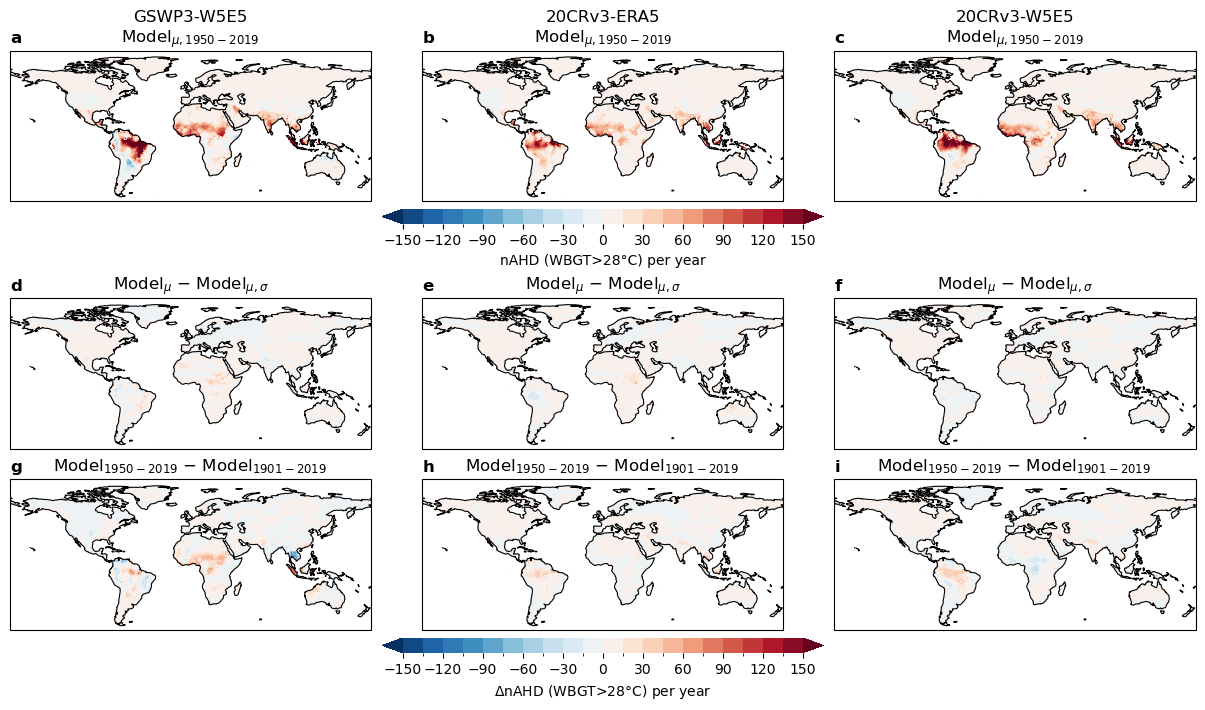

In [49]:
import string
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker


# Settings
proj = crs = ccrs.PlateCarree()

cmap = 'RdBu_r' 
vmin, vmax, levels = -150,150, 21 # before: -200, 200, 16)

# Labels 
titles = [f"{letter}" for letter in string.ascii_lowercase[:13]]

# Create figure layout
fig = plt.figure(figsize=(12,10), layout='constrained')
gs = gridspec.GridSpec(5, 3, figure=fig)

# Plot observed data
for j in range(3):
    ax = fig.add_subplot(gs[0, j:j+1], projection=proj)
    data_plot = da_nAHD_obs_ls.isel(dataset=j) * landmask # loc short model 
    plot = plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j],
                 vmin=vmin,vmax=vmax,cmap=cmap,levels=levels,
                 title_text=f'{data_plot.dataset.values}'+'\nModel$_{\mu,1950-2019}$' )

    if j==1:
        cbar = fig.colorbar(plot, extend='both', ax=ax, location='bottom', shrink=1.2, fraction=0.12, aspect=30) # original: shrink=.9, fraction=0.12, aspect=25
        cbar.set_label('nAHD (WBGT>28°C) per year', )
        cbar.outline.set_edgecolor('none')
        cbar.ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=11))  # Adjust major tick count
        cbar.ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(n=2))  # 1 minor tick per major tick
    #print(data_plot.min().values, data_plot.max().values)
        



for j in range(3):
    ax = fig.add_subplot(gs[1, j:j+1], projection=proj)
    data_plot = (da_nAHD_obs_ls-da_nAHD_obs_lss).isel(dataset=j) * landmask # loc short - log sigma short (STILL NEEDS TO BE UPDATED !!) 
    plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j+3],
                  vmin=vmin,vmax=vmax,cmap=cmap,levels=levels,
                  title_text='Model$_{\mu}$ $-$ Model$_{\mu, \sigma}$ '
                 )
    #print(data_plot.min().values, data_plot.max().values)


for j in range(3):
    ax = fig.add_subplot(gs[2, j:j+1], projection=proj)
    data_plot = (da_nAHD_obs_ls-da_nAHD_obs_ll).isel(dataset=j) * landmask # loc short - loc long
    plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j+6],
                  vmin=vmin,vmax=vmax,cmap=cmap,levels=levels,
                 title_text='Model$_{1950-2019}$ $-$ Model$_{1901-2019}$ ')
    #print(data_plot.min().values, data_plot.max().values)

    if j==1:
        # Colorbar
        cbar = fig.colorbar(plot, extend='both', ax=ax, location='bottom', shrink=1.2, fraction=0.12, aspect=30)
        cbar.set_label('$\Delta$nAHD (WBGT>28°C) per year', )
        cbar.outline.set_edgecolor('none')
        cbar.ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=11))  # Adjust major tick count
        cbar.ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(n=2))  # 1 minor tick per major tick


#plt.savefig(os.path.join(figdir,'figSI10_sensshiftfit.pdf'),dpi=300,transparent=True)
#plt.savefig(os.path.join(figdir,'figSI10_sensshiftfit.png'),dpi=300,transparent=True)

## Other versions: 

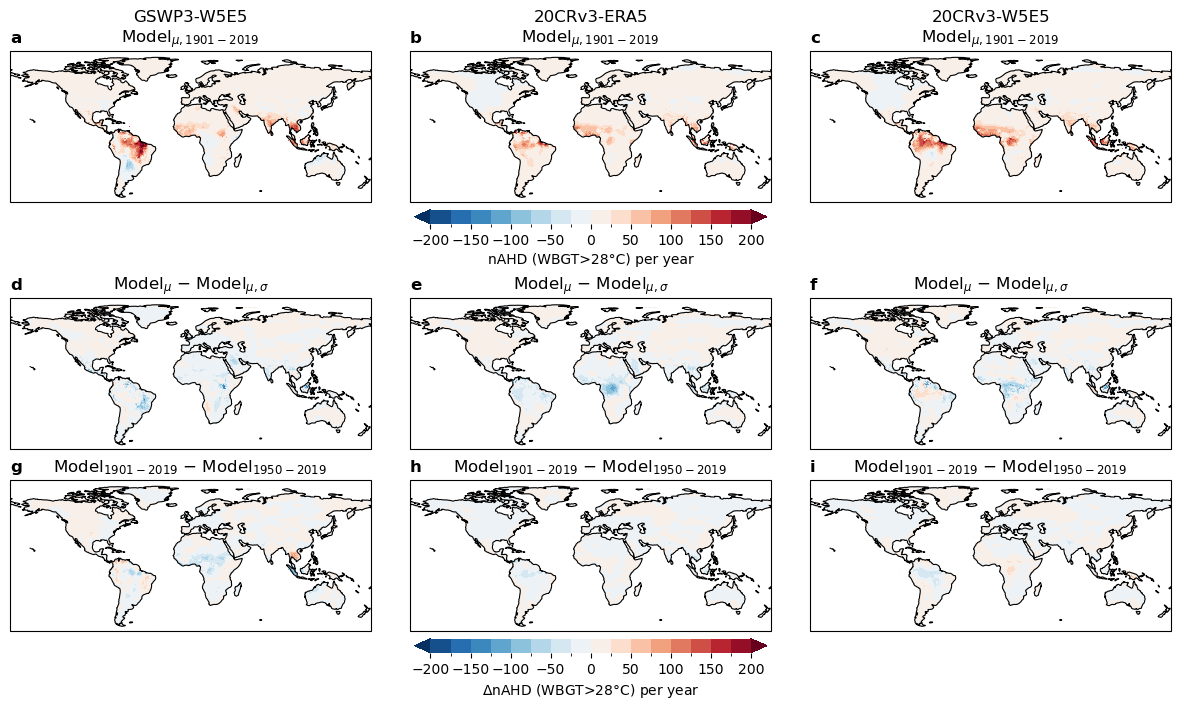

In [50]:
import string
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec


# Settings
proj = crs = ccrs.PlateCarree()
# cmap = LinearSegmentedColormap.from_list('new_RdBu_r', plt.get_cmap('RdBu_r')(np.linspace(0.25, 1, 192))) 
# vmin, vmax, levels = -100, 200, np.linspace(-100, 200, 16)

cmap = 'RdBu_r' #LinearSegmentedColormap.from_list('new_RdBu_r', plt.get_cmap('RdBu_r')(np.linspace(0.25, 1, 192))) 
vmin, vmax, levels = -200,200, 17 # np.linspace(-200, 200, 16)

#norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# Labels 
titles = [f"{letter}" for letter in string.ascii_lowercase[:13]]

# Create figure layout
fig = plt.figure(figsize=(12,10), layout='constrained')
gs = gridspec.GridSpec(5, 3, figure=fig)

# Plot observed data
for j in range(3):
    ax = fig.add_subplot(gs[0, j:j+1], projection=proj)
    data_plot = da_nAHD_obs_ll.isel(dataset=j) * landmask
    plot = plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j],
                 vmin=vmin,vmax=vmax,cmap=cmap,levels=levels,
                 title_text=f'{data_plot.dataset.values}'+'\nModel$_{\mu,1901-2019}$' )

    if j==1:
        # Colorbar
        cbar = fig.colorbar(plot, extend='both', ax=ax, location='bottom', shrink=.9, fraction=0.12, aspect=25)
        cbar.set_label('nAHD (WBGT>28°C) per year', )
        cbar.outline.set_edgecolor('none')
        



for j in range(3):
    ax = fig.add_subplot(gs[1, j:j+1], projection=proj)
    data_plot = (da_nAHD_obs_ll-da_nAHD_obs_lsl).isel(dataset=j) * landmask
    plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j+3],
                  vmin=vmin,vmax=vmax,cmap=cmap,levels=levels,
                  title_text='Model$_{\mu}$ $-$ Model$_{\mu, \sigma}$ '
                 )


for j in range(3):
    ax = fig.add_subplot(gs[2, j:j+1], projection=proj)
    data_plot = (da_nAHD_obs_ll-da_nAHD_obs_ls).isel(dataset=j) * landmask
    plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j+6],
                  vmin=vmin,vmax=vmax,cmap=cmap,levels=levels,
                 title_text='Model$_{1901-2019}$ $-$ Model$_{1950-2019}$ ')

    if j==1:
        # Colorbar
        cbar = fig.colorbar(plot, extend='both', ax=ax, location='bottom', shrink=.9, fraction=0.12, aspect=25)
        cbar.set_label('$\Delta$nAHD (WBGT>28°C) per year', )
        cbar.outline.set_edgecolor('none')



# plt.savefig(os.path.join(figdir,'fig_SI_sensshiftfit.pdf'),dpi=300,transparent=True)
# plt.savefig(os.path.join(figdir,'fig_SI_sensshiftfit.png'),dpi=300,transparent=True)


Also -200,200 but now same cbar separation as other plots

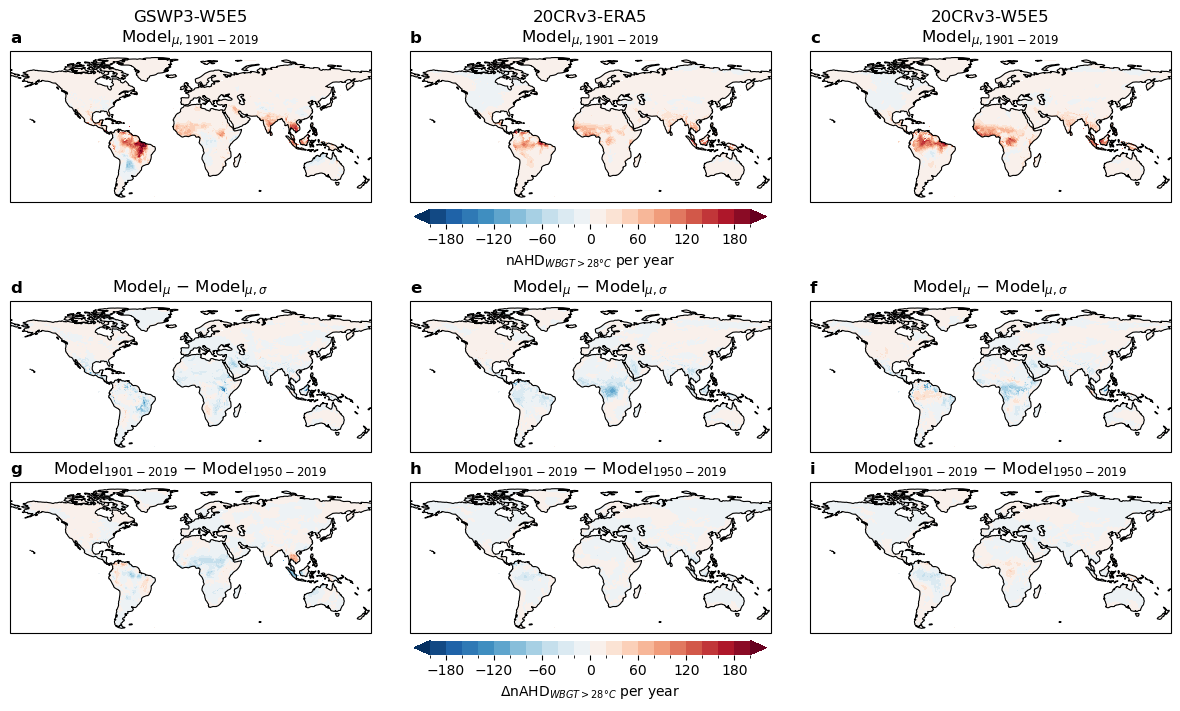

In [51]:
import string
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec


# Settings
proj = crs = ccrs.PlateCarree()
# cmap = LinearSegmentedColormap.from_list('new_RdBu_r', plt.get_cmap('RdBu_r')(np.linspace(0.25, 1, 192))) 
# vmin, vmax, levels = -100, 200, np.linspace(-100, 200, 16)

cmap = 'RdBu_r' #LinearSegmentedColormap.from_list('new_RdBu_r', plt.get_cmap('RdBu_r')(np.linspace(0.25, 1, 192))) 
vmin, vmax, levels = -200,200, 21 # np.linspace(-200, 200, 16)

#norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# Labels 
titles = [f"{letter}" for letter in string.ascii_lowercase[:13]]

# Create figure layout
fig = plt.figure(figsize=(12,10), layout='constrained')
gs = gridspec.GridSpec(5, 3, figure=fig)

# Plot observed data
for j in range(3):
    ax = fig.add_subplot(gs[0, j:j+1], projection=proj)
    data_plot = da_nAHD_obs_ll.isel(dataset=j) * landmask
    plot = plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j],
                 vmin=vmin,vmax=vmax,cmap=cmap,levels=levels,
                 title_text=f'{data_plot.dataset.values}'+'\nModel$_{\mu,1901-2019}$' )

    if j==1:
        # Colorbar
        cbar = fig.colorbar(plot, extend='both', ax=ax, location='bottom', shrink=.9, fraction=0.12, aspect=25)
        cbar.set_label('nAHD$_{WBGT>28°C}$ per year', )
        cbar.outline.set_edgecolor('none')
        



for j in range(3):
    ax = fig.add_subplot(gs[1, j:j+1], projection=proj)
    data_plot = (da_nAHD_obs_ll-da_nAHD_obs_lsl).isel(dataset=j) * landmask
    plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j+3],
                  vmin=vmin,vmax=vmax,cmap=cmap,levels=levels,
                  title_text='Model$_{\mu}$ $-$ Model$_{\mu, \sigma}$ '
                 )


for j in range(3):
    ax = fig.add_subplot(gs[2, j:j+1], projection=proj)
    data_plot = (da_nAHD_obs_ll-da_nAHD_obs_ls).isel(dataset=j) * landmask
    plot = plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j+6],
                  vmin=vmin,vmax=vmax,cmap=cmap,levels=levels,
                 title_text='Model$_{1901-2019}$ $-$ Model$_{1950-2019}$ ')

    if j==1:
        # Colorbar
        cbar = fig.colorbar(plot, extend='both', ax=ax, location='bottom', shrink=.9, fraction=0.12, aspect=25)
        cbar.set_label('$\Delta$nAHD$_{WBGT>28°C}$ per year', )
        cbar.outline.set_edgecolor('none')



# plt.savefig(os.path.join(figdir,'fig_SI_sensshiftfit.pdf'),dpi=300,transparent=True)
# plt.savefig(os.path.join(figdir,'fig_SI_sensshiftfit.png'),dpi=300,transparent=True)




With different cbar for difference to better see it

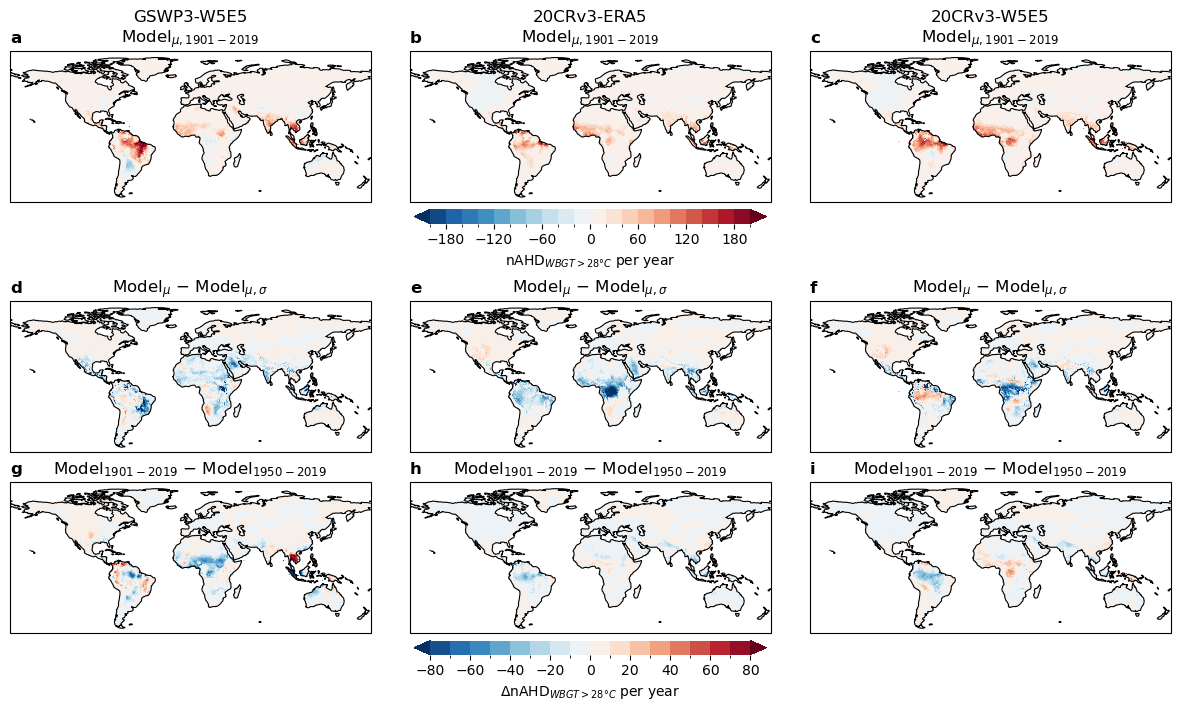

In [52]:
import string
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec


# Settings
proj = crs = ccrs.PlateCarree()
# cmap = LinearSegmentedColormap.from_list('new_RdBu_r', plt.get_cmap('RdBu_r')(np.linspace(0.25, 1, 192))) 
# vmin, vmax, levels = -100, 200, np.linspace(-100, 200, 16)

cmap = 'RdBu_r' #LinearSegmentedColormap.from_list('new_RdBu_r', plt.get_cmap('RdBu_r')(np.linspace(0.25, 1, 192))) 
vmin, vmax, levels = -200,200, 21 # np.linspace(-200, 200, 16)

#norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# Labels 
titles = [f"{letter}" for letter in string.ascii_lowercase[:13]]

# Create figure layout
fig = plt.figure(figsize=(12,10), layout='constrained')
gs = gridspec.GridSpec(5, 3, figure=fig)

# Plot observed data
for j in range(3):
    ax = fig.add_subplot(gs[0, j:j+1], projection=proj)
    data_plot = da_nAHD_obs_ll.isel(dataset=j) * landmask
    plot = plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j],
                 vmin=vmin,vmax=vmax,cmap=cmap,levels=levels,
                 title_text=f'{data_plot.dataset.values}'+'\nModel$_{\mu,1901-2019}$' )

    if j==1:
        # Colorbar
        cbar = fig.colorbar(plot, extend='both', ax=ax, location='bottom', shrink=.9, fraction=0.12, aspect=25)
        cbar.set_label('nAHD$_{WBGT>28°C}$ per year', )
        cbar.outline.set_edgecolor('none')
        

vmin, vmax, levels = -80,80, 17

for j in range(3):
    ax = fig.add_subplot(gs[1, j:j+1], projection=proj)
    data_plot = (da_nAHD_obs_ll-da_nAHD_obs_lsl).isel(dataset=j) * landmask
    plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j+3],
                  vmin=vmin,vmax=vmax,cmap=cmap,levels=levels,
                  title_text='Model$_{\mu}$ $-$ Model$_{\mu, \sigma}$ '
                 )


for j in range(3):
    ax = fig.add_subplot(gs[2, j:j+1], projection=proj)
    data_plot = (da_nAHD_obs_ll-da_nAHD_obs_ls).isel(dataset=j) * landmask
    plot = plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j+6],
                  vmin=vmin,vmax=vmax,cmap=cmap,levels=levels,
                 title_text='Model$_{1901-2019}$ $-$ Model$_{1950-2019}$ ')

    if j==1:
        # Colorbar
        cbar = fig.colorbar(plot, extend='both', ax=ax, location='bottom', shrink=.9, fraction=0.12, aspect=25)
        cbar.set_label('$\Delta$nAHD$_{WBGT>28°C}$ per year', )
        cbar.outline.set_edgecolor('none')



#plt.savefig(os.path.join(figdir,'fig_SI_sensshiftfit_v2.pdf'),dpi=300,transparent=True)
#plt.savefig(os.path.join(figdir,'fig_SI_sensshiftfit_v2.png'),dpi=300,transparent=True)
